In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#| code-fold: false
# IMPORTING LIBRARIES
# --------------------

# AstroML
from astroML.datasets import fetch_LINEAR_sample
from astropy.timeseries import LombScargle
from astroML.datasets import fetch_LINEAR_sample
from astroML.datasets import fetch_LINEAR_geneva
from astropy.timeseries import TimeSeries
from astropy.table import Table
from astroML.time_series import MultiTermFit

# ZTF
from ztfquery import lightcurve

# Basic libraries
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties

# DataFrame analysis
import pandas as pd

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm

# CONFIGURATION
# -------------
sns.set_theme(style='white') # setting the theme for plotting
sys.path.insert(0,'../src/')
np.random.seed(42)

# configuring plotting colors
colors = ['#465BBB', '#3F8FCE', '#7ABBCE', '#3A3865', '#A82F43', '#612A37', '#DC5433', '#F29457']
b1 = '#465BBB'
b2 = '#3F8FCE'
b3 = '#7ABBCE'
b4 = '#3A3865'
black1 = '#22212A'
black2 = '#2D1E21'
or1 = '#A82F43'
or2 = '#612A37'
or3 = '#DC5433'
or4 = '#F29457'
muted_colors = sns.set_palette(sns.color_palette(colors))

# configuring fonts for plotting
font = FontProperties()
font.set_family('serif')
font.set_name('Andale Mono')
font.set_style('normal')
#font.set_size('normal')


%matplotlib inline 

In [3]:
#| code-fold: false
# Importing custom libraries
# ----------------------------
from data_access import*
from helper import*
from RR_lyrae_params import*
from blazhko_analysis import*
from BE_plotting import*

In [5]:
# DATA
# ======
# LINEAR data
dataL = fetch_LINEAR_sample(data_home='../inputs')

# calcualted data
end = 'ffinal'

# light curve table
lc_analysis = pd.read_csv("../outputs/LC_ANALYSIS_"+end+".csv")
# rr lyrae
rrlyrae = pd.read_csv('../outputs/Lrrlyr_unprocessed.csv')
# blazhko candidates
blazhko_candidates = pd.read_csv('../outputs/blazhko_canmodfinal.csv')
# periodogram data
periodogr = pickle.load(open("../outputs/periodograms_"+end+".pkl", "rb"))
# fits data
fits = np.load("../outputs/fits_"+end+".npy", allow_pickle=True)
# ztf data
ztf_data = np.load("../outputs/ztf_data_filter"+end+".npy", allow_pickle=True)

# selection data
ztf_per = pd.read_csv('../outputs/groupZ_p.csv')
linear_per = pd.read_csv('../outputs/groupL_p.csv')
score = pd.read_csv('../outputs/group_score.csv')

---

In [11]:
FINAL_BE_CATALOGUE = pd.read_csv('../outputs/be_final.csv')

# Analysis of final catalogue

### Adding the light curve type

In [9]:
lctype = []

for i in range(len(list(rrlyrae['LINEARobjectID']))):
    lctype.append((rrlyrae['LINEARobjectID'][i], rrlyrae['LCtype'][i]))

be_lctype = []
for i in list(lc_analysis['LINEAR id']):
    for n in lctype:
        if i==n[0]:
            be_lctype.append(n)
print(len(be_lctype))

LCTYPE = [x[1] for x in be_lctype]

lc_analysis['LCtype'] = LCTYPE
lc_analysis.head()

2857


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_chi2dof,L_chi2dofR,Lmean_chi2dof,Lmean_chi2dofR,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score,LCtype
0,29848,0.557020,0.557040,0.557030,1.000036,301,3.0,1.4,3.3,1.6,...,1.7982,333.3333,0.2573,10.0729,0.37,0.00004,NaN,NaN,NaN,1
1,50402,0.643303,0.643294,0.643298,0.999986,284,0.6,0.7,0.6,0.7,...,1.5918,26.8420,0.0027,8.9208,0.21,0.00001,NaN,NaN,NaN,1
2,62892,0.530776,0.530785,0.530780,1.000017,276,1.1,0.9,1.1,1.0,...,1.9433,16.8634,0.0048,13.1609,0.02,0.00002,NaN,NaN,NaN,1
3,91437,0.674733,0.674737,0.674735,1.000006,177,2.8,1.3,2.8,1.3,...,1.4849,355.8719,0.0233,16.1566,0.34,0.00001,NaN,NaN,NaN,1
4,95250,0.313870,0.313876,0.313873,1.000019,222,0.8,0.8,0.9,0.8,...,3.1889,342.4658,0.0028,13.4528,0.02,0.00002,NaN,NaN,NaN,2


### The master table

In [10]:
lc_MASTER = pd.DataFrame(())
lc_MASTER['LINEAR ID'] = lc_analysis['LINEAR id']
lc_MASTER['Plinear'] = lc_analysis['Plinear']
lc_MASTER['Pztf'] = lc_analysis['Pztf']
lc_MASTER['N_L'] = lc_analysis['NdataLINEAR']
lc_MASTER['N_Z'] = lc_analysis['NdataZTF']
lc_MASTER['L_chi2r'] = lc_analysis['L_chi2dofR']
lc_MASTER['Z_chi2r'] = lc_analysis['Zchi2dofR']
lc_MASTER['L_chi2'] = lc_analysis['L_chi2dof']
lc_MASTER['Z_chi2'] = lc_analysis['Zchi2dof']
lc_MASTER['Lampl'] = lc_analysis['Lampl']
lc_MASTER['Zampl'] = lc_analysis['Zampl']
lc_MASTER['Ampl_diff'] = lc_analysis['Ampl_diff']
lc_MASTER['BpeakL'] = lc_analysis['BlazhkoPeakL']
lc_MASTER['BpeakZ'] = lc_analysis['BlazhkoPeakZ']
lc_MASTER['BperiodL'] = lc_analysis['BlazhkoPeriodL']
lc_MASTER['BperiodZ'] = lc_analysis['BlazhkoPeriodZ']
lc_MASTER['LCtype'] = lc_analysis['LCtype']
lc_MASTER['Periodogram_f'] = '-'
lc_MASTER['B_score'] = 0  # Assuming a default value of 0 for B_score
lc_MASTER['Blazhko_f'] = '-1'  # Default value

In [12]:
lcLids = list(lc_MASTER['LINEAR ID'])
bcLids = list(blazhko_candidates['LINEAR id'])
bLids = list(FINAL_BE_CATALOGUE['LINEAR id'])

In [13]:
for n, i in enumerate(lcLids):
    for m, j in enumerate(bcLids):
        if i == j:
            if blazhko_candidates.loc[m, 'BE_score'] > 0:
                lc_MASTER.loc[n, 'B_score'] = blazhko_candidates.loc[m, 'BE_score']
            for nm, k in enumerate(bLids):
                if i == k:
                    if FINAL_BE_CATALOGUE.loc[nm, 'IndicatorType'] == 'Z' or FINAL_BE_CATALOGUE.loc[nm, 'IndicatorType'] == 'L' or FINAL_BE_CATALOGUE.loc[nm, 'IndicatorType'] == 'LZ':
                        lc_MASTER.loc[n, 'Periodogram_f'] = FINAL_BE_CATALOGUE.loc[nm, 'IndicatorType']
                        lc_MASTER.loc[n, 'Blazhko_f'] = '2'
                    else:
                        lc_MASTER.loc[n, 'Blazhko_f'] = '1'
                    break  
                else:
                    lc_MASTER.loc[n, 'Blazhko_f'] = '0'
            break 

In [21]:
lc_MASTER.head(40)

,LINEAR ID,Plinear,Pztf,N_L,N_Z,L_chi2r,Z_chi2r,L_chi2,Z_chi2,Lampl,Zampl,Ampl_diff,BpeakL,BpeakZ,BperiodL,BperiodZ,LCtype,Periodogram_f,B_score,Blazhko_f
0,29848,0.557020,0.557040,301,43,1.4,3.5,3.0,12.6,0.56,0.93,0.37,1.8328,1.7982,26.6205,333.3333,1,-,0,-1
1,50402,0.643303,0.643294,284,586,0.7,1.1,0.6,1.8,0.48,0.69,0.21,1.6223,1.5918,14.7351,26.8420,1,-,0,-1
2,62892,0.530776,0.530785,276,771,0.9,3.2,1.1,19.8,0.62,0.64,0.02,1.9519,1.9433,14.7319,16.8634,1,-,0,-1
3,91437,0.674733,0.674737,177,564,1.3,2.0,2.8,5.6,0.87,1.21,0.34,1.5498,1.4849,14.7580,355.8719,1,-,0,-1
4,95250,0.313870,0.313876,222,916,0.8,1.4,0.8,3.0,0.48,0.46,0.02,3.2565,3.1889,14.1844,342.4658,2,-,0,-1
5,104455,0.997195,0.997587,119,44,1.6,17.6,3.4,184.1,4141.12,42446.41,38305.29,1.0058,1.0499,336.1345,21.0682,1,-,0,-1
6,108513,0.473809,1.000362,282,42,1.4,10.9,4.0,161.1,0.86,26072.93,26072.07,2.1465,1.0034,27.8203,266.3116,1,-,0,-1
7,136668,0.532923,0.532929,310,918,1.1,2.3,1.6,17.0,0.82,0.78,0.04,1.9095,1.9396,30.2847,15.8391,1,-,0,-1
8,141414,0.335690,0.335669,278,919,0.8,1.5,0.6,2.6,0.41,0.37,0.04,3.0467,2.9930,14.7504,71.8907,2,-,0,-1
9,142794,0.470787,0.470802,270,63,1.0,2.3,1.8,11.9,0.72,0.72,0.00,2.1848,2.1851,16.4880,16.3626,1,-,0,-1


In [15]:
lc_MASTER.to_csv("../outputs/lc_MASTER.csv", index=False)

In [18]:
with open('../PAPER/lc_master.tex', "w") as f:
    f.write(lc_MASTER.to_latex(index=False))

/var/folders/t5/p2kd2rtd7bz4dz4p833qfm3w0000gn/T/ipykernel_10427/2370270825.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(lc_MASTER.to_latex(index=False))


## Selecting blazhko stars from the main catalogue

In [32]:
b_can = lc_MASTER[lc_MASTER['Blazhko_f'].isin(['0', '1', '2'])].copy()

print(b_can.shape)
b_can.head()

(531, 20)


,LINEAR ID,Plinear,Pztf,N_L,N_Z,L_chi2r,Z_chi2r,L_chi2,Z_chi2,Lampl,Zampl,Ampl_diff,BpeakL,BpeakZ,BperiodL,BperiodZ,LCtype,Periodogram_f,B_score,Blazhko_f
10,158779,0.609207,0.609189,293,616,1.6,3.9,3.7,34.2,0.47,0.68,0.21,1.6443,1.6444,352.7337,350.2627,1,-,7,1
18,263541,0.558218,0.558221,270,503,2.9,6.6,15.8,110.4,0.64,0.82,0.18,1.8621,1.8025,14.1513,89.9685,1,-,7,1
22,393084,0.530027,0.530033,493,372,1.1,3.2,1.6,19.2,0.96,1.31,0.35,1.9447,1.8896,17.2369,347.2222,1,-,6,1
27,514883,0.557723,0.557737,289,555,1.7,5.5,5.3,53.7,0.55,0.72,0.17,1.8472,1.7958,18.4655,357.1429,1,-,8,0
37,737951,0.357023,0.357023,273,871,2.2,6.7,6.0,42.4,0.43,0.34,0.09,2.8038,2.8039,353.3569,332.2259,2,-,6,0


In [60]:
be_MAIN = lc_MASTER[lc_MASTER['Blazhko_f'].isin(['1', '2'])].copy()

print(be_MAIN.shape)
be_MAIN.head()

(228, 20)


,LINEAR ID,Plinear,Pztf,N_L,N_Z,L_chi2r,Z_chi2r,L_chi2,Z_chi2,Lampl,Zampl,Ampl_diff,BpeakL,BpeakZ,BperiodL,BperiodZ,LCtype,Periodogram_f,B_score,Blazhko_f
10,158779,0.609207,0.609189,293,616,1.6,3.9,3.7,34.2,0.47,0.68,0.21,1.6443,1.6444,352.7337,350.2627,1,-,7,1
18,263541,0.558218,0.558221,270,503,2.9,6.6,15.8,110.4,0.64,0.82,0.18,1.8621,1.8025,14.1513,89.9685,1,-,7,1
22,393084,0.530027,0.530033,493,372,1.1,3.2,1.6,19.2,0.96,1.31,0.35,1.9447,1.8896,17.2369,347.2222,1,-,6,1
41,810169,0.465185,0.465212,289,743,2.1,2.8,6.0,15.1,0.77,0.75,0.02,2.2232,2.2230,13.6017,13.6082,1,-,5,1
54,924301,0.507503,0.507440,418,189,1.9,9.3,13.8,162.9,0.87,0.79,0.08,2.0043,1.9763,29.5072,178.4121,1,-,8,1


In [30]:
with open('../PAPER/be_master.tex', "w") as f:
    f.write(be_MAIN.to_latex(index=False))

/var/folders/t5/p2kd2rtd7bz4dz4p833qfm3w0000gn/T/ipykernel_10427/827175474.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(be_MAIN.to_latex(index=False))


# Plots

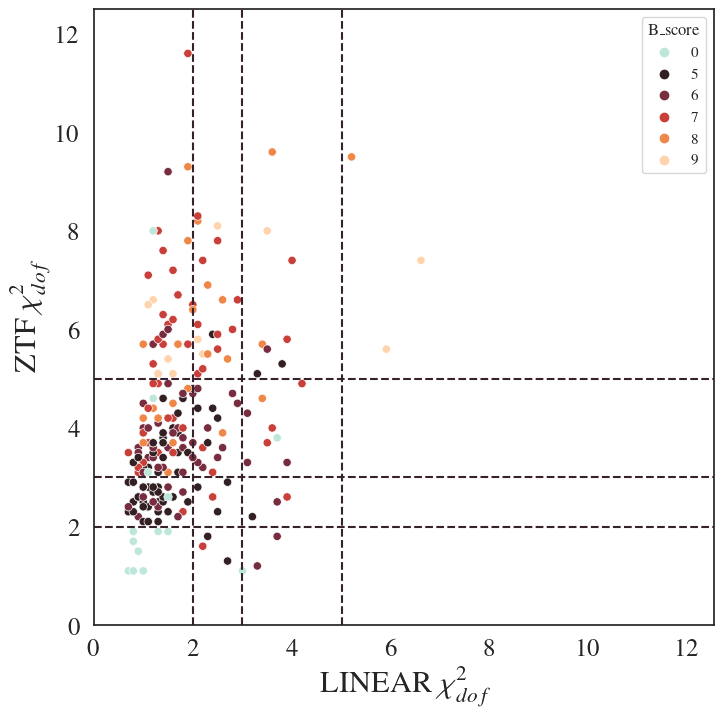

In [78]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(xscale='linear', yscale='linear') 
ax.xaxis.set_tick_params(labelsize=18) 
ax.yaxis.set_tick_params(labelsize=18) 
plt.rc('font', size=24) 


#sns.scatterplot(data=lc_analysis, x='L_chi2dofR', y='Zchi2dofR', marker='x', color=b1)
sns.scatterplot(data=be_MAIN, x='L_chi2r', y='Z_chi2r', marker='o', hue='B_score', palette='icefire')

plt.xlim([0, 12.5]) # limit of 12.5, because above 12.5 there is no point, something is wrong with the data
plt.ylim([0, 12.5])
plt.xlabel(r'LINEAR $\chi_{dof}^2$', fontproperties=font, fontsize=22)
plt.ylabel(r'ZTF $\chi_{dof}^2$', fontproperties=font,fontsize=22)

plt.plot([2.0, 2.0], [0, 12.5], ls='--', c=black1)
plt.plot([3.0, 3.0], [0, 12.5], ls='--', c=black1)
plt.plot([0, 12.5], [2.0, 2.0], ls='--', c=black1)
plt.plot([0, 12.5], [3.0, 3.0], ls='--', c=black1)
plt.plot([5.0, 5.0], [0, 12.5], ls='--', c=black1)
plt.plot([0, 12.5], [5.0, 5.0], ls='--', c=black1)
plt.savefig('../images_paper/final_chi2_b.png', dpi=150)

plt.show()

- algorithm success
- incidence rate

In [41]:
# Algorithm success:

print((len(be_MAIN['LINEAR ID']) / len(b_can['LINEAR ID']))*100,'%')

42.93785310734463 %


In [46]:
# Incidence rate:

print((len(be_MAIN['LINEAR ID']) / rrlyrae.shape[0])*100,'%')

7.752465147908874 %


---

In [61]:
be_MAIN.head()

,LINEAR ID,Plinear,Pztf,N_L,N_Z,L_chi2r,Z_chi2r,L_chi2,Z_chi2,Lampl,Zampl,Ampl_diff,BpeakL,BpeakZ,BperiodL,BperiodZ,LCtype,Periodogram_f,B_score,Blazhko_f
10,158779,0.609207,0.609189,293,616,1.6,3.9,3.7,34.2,0.47,0.68,0.21,1.6443,1.6444,352.7337,350.2627,1,-,7,1
18,263541,0.558218,0.558221,270,503,2.9,6.6,15.8,110.4,0.64,0.82,0.18,1.8621,1.8025,14.1513,89.9685,1,-,7,1
22,393084,0.530027,0.530033,493,372,1.1,3.2,1.6,19.2,0.96,1.31,0.35,1.9447,1.8896,17.2369,347.2222,1,-,6,1
41,810169,0.465185,0.465212,289,743,2.1,2.8,6.0,15.1,0.77,0.75,0.02,2.2232,2.2230,13.6017,13.6082,1,-,5,1
54,924301,0.507503,0.507440,418,189,1.9,9.3,13.8,162.9,0.87,0.79,0.08,2.0043,1.9763,29.5072,178.4121,1,-,8,1


In [74]:
# lc type:
lc_type = be_MAIN['LCtype'].value_counts()
lc_type

1    180
2     48
Name: LCtype, dtype: int64

In [77]:
print('Percentage of RRAB stars is ', (180/(180+48))*100, '%')
print('Percentage of RRC stars is ', (48/(180+48))*100, '%')


Percentage of RRAB stars is  78.94736842105263 %
Percentage of RRC stars is  21.052631578947366 %


In [79]:
print(np.mean(be_MAIN['L_chi2r']))

1.7828947368421053


In [80]:
print(np.mean(be_MAIN['Z_chi2r']))

4.098684210526316


In [81]:
# chi2 area:
chi2area = FINAL_BE_CATALOGUE['ChiType'].value_counts()
chi2area

LZ4    94
LZ5    66
LZ3    54
-      14
Name: ChiType, dtype: int64

In [82]:
print(np.mean(be_MAIN['B_score']))

5.9035087719298245


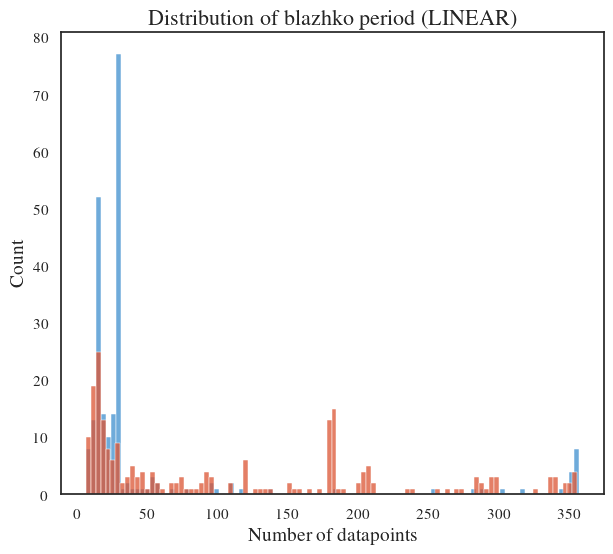

In [ ]:
plt.figure(figsize=(7,6))
sns.histplot(data=be_MAIN['BperiodL'].to_numpy(), color=b2, bins=100)
sns.histplot(data=be_MAIN['BperiodZ'].to_numpy(), color=or3, bins=100)
plt.title('Distribution of blazhko period',fontproperties=font,fontsize=16)
plt.xlabel('Number of datapoints', fontproperties=font, fontsize=14)
plt.ylabel('Count', fontproperties=font,fontsize=14)
plt.show()